In [ ]:
# For importing utils
import sys
sys.path.append("..")


In [ ]:
PERTURBATIONS = {
    "en_30000": {"color": "#ADD8E6"},  # Light Blue
    "en_40000": {"color": "#87CEEB"},  # Sky Blue
    "en_50000": {"color": "#5F9EA0"},  # Cadet Blue
    "en_60000": {"color": "#4682B4"},  # Steel Blue
    "en_70000": {"color": "#4169E1"},  # Royal Blue
    "en_80000": {"color": "#000080"},  # Navy

    "de_30000": {"color": "#FFDAB9"},  # Peach Puff
    "de_40000": {"color": "#FFA07A"},  # Light Salmon
    "de_50000": {"color": "#FF6347"},  # Tomato
    "de_60000": {"color": "#FF4500"},  # Orange Red
    "de_70000": {"color": "#FF8C00"},  # Dark Orange
    "de_80000": {"color": "#8B0000"},  # Dark Red

    "ru_30000": {"color": "#2E0854"},  # Lavender
    "ru_40000": {"color": "#9370DB"},  # Medium Purple
    "ru_50000": {"color": "#7B68EE"},  # Medium Slate Blue
    "ru_60000": {"color": "#6A5ACD"},  # Slate Blue
    "ru_70000": {"color": "#4B0082"},  # Indigo
    "ru_80000": {"color": "#E6E6FA"},  # Midnight Purple

    "ro_30000": {"color": "#800080"},  # Misty Rose
    "ro_40000": {"color": "#FFB6C1"},  # Light Pink
    "ro_50000": {"color": "#FF69B4"},  # Hot Pink
    "ro_60000": {"color": "#DB7093"},  # Pale Violet Red
    "ro_70000": {"color": "#C71585"},  # Medium Violet Red
    "ro_80000": {"color": "#FFE4E1"},  # Purple

    "tr_30000": {"color": "#98FB98"},  # Pale Green
    "tr_40000": {"color": "#90EE90"},  # Light Green
    "tr_50000": {"color": "#32CD32"},  # Lime Green
    "tr_60000": {"color": "#228B22"},  # Forest Green
    "tr_70000": {"color": "#006400"},  # Dark Green
    "tr_80000": {"color": "#013220"},  # Very Dark Green
     "tr_pretrain": {"color": "#90EE90"},
}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, checkpoints, seeds, merge, pos_encodings, warmup):
    
    nps = "" if pos_encodings else "_no_positional_encodings"
    wp = "_warmup" if warmup else ""

    results_path = '/Users/xiulinyang/Desktop/test/mission-impossible-language-models/perplexities/perplexity_results/shuffle_control_{}_{}/randinit_seed{}_test_shuffle_control_{}_{}.csv'
    average_values = {}
    for file_data in file_info:
        lang, lang2, vocab_size, marker, linestyle, legend_name= file_data

        all_seeds_gmeans = []
        for seed in seeds:
            df = pd.read_csv(results_path.format(lang, lang2, seed, lang, vocab_size),lineterminator='\n')
            gmeans = []
            min_means = []
            # Calculate geometric means for each checkpoint
            for ckpt in checkpoints:
                gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))
                min_means.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))
                
            if merge:
                gmeans = [min(min_means)]
            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)
        # ci = None
        # if len(seeds) > 1:
        #     sems = stats.sem(all_seeds_gmeans, axis=0)
        #     # Calculate confidence interval using t-distribution
        #     ci_lower, ci_upper = stats.t.interval(0.95, df=len(seeds)-1,
        #                                         loc=means, scale=sems)
        #     ci = (ci_upper - ci_lower) / 2

        #     ax.errorbar(checkpoints, means, ci, marker=marker, 
        #                 color=PERTURBATIONS[f'{lang}_{vocab_size}']["color"],
        #                 linestyle=linestyle, label=legend_name)
        # if len(seeds) > 1:
            # Calculate the 25th and 75th percentiles (quartiles)
        lower_percentile = np.percentile(all_seeds_gmeans, 25, axis=0)
        upper_percentile = np.percentile(all_seeds_gmeans, 75, axis=0)
        
        # Calculate the error bars as the difference between the percentiles
        iqr_lower = means - lower_percentile  # Lower quartile error
        iqr_upper = upper_percentile - means  # Upper quartile error
        ax.errorbar(checkpoints, means, yerr=[iqr_lower, iqr_upper], marker=marker, markersize=4, linewidth=0.8,
                    color=PERTURBATIONS[f'{lang}_{vocab_size}']["color"],
                    linestyle=linestyle, label=legend_name)

            
        ax.set_title(title)
        if ax_i == 0:
            ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
        
        if not pos_encodings and title == "*Shuffle":
            ax.legend(fontsize=6)
        elif title == "*Shuffle":
            ax.legend(fontsize=8, framealpha=1)
        else:
            ax.legend(fontsize=8, framealpha=1)
        ax.grid(True, color="lightgray")
    # if merge:
    #     return average_values

In [ ]:
def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, merge=False, pos_encodings=True, warmup=False):
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 3, figsize=(16, 3*2), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)

    # Flatten axs to handle cases with multiple rows, or wrap in a list for single subplot
    axs_flat = [axs] if len(file_infos) == 1 else axs.flatten()

    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, merge, pos_encodings, warmup
        )

    # Turn off unused subplots
    for ax in axs_flat[len(file_infos):]:
        ax.axis("off")  # Hide extra plots

    plt.tight_layout()
    plt.savefig("tokenization_results.pdf", format="pdf", bbox_inches="tight")  # Save first
    plt.show()  # Then show

In [ ]:
def plot_perplexities_grouped_merge(file_infos, titles, checkpoints, seeds, merge=True, pos_encodings=True, warmup=False):
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    
    # axs_flat = axs.flatten()
    axs_flat = [axs] if len(file_infos) == 1 else axs.flatten()
    all_vas = []
    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        average_vas = plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, merge, pos_encodings, warmup)
        all_vas.append(average_vas)
    return all_vas

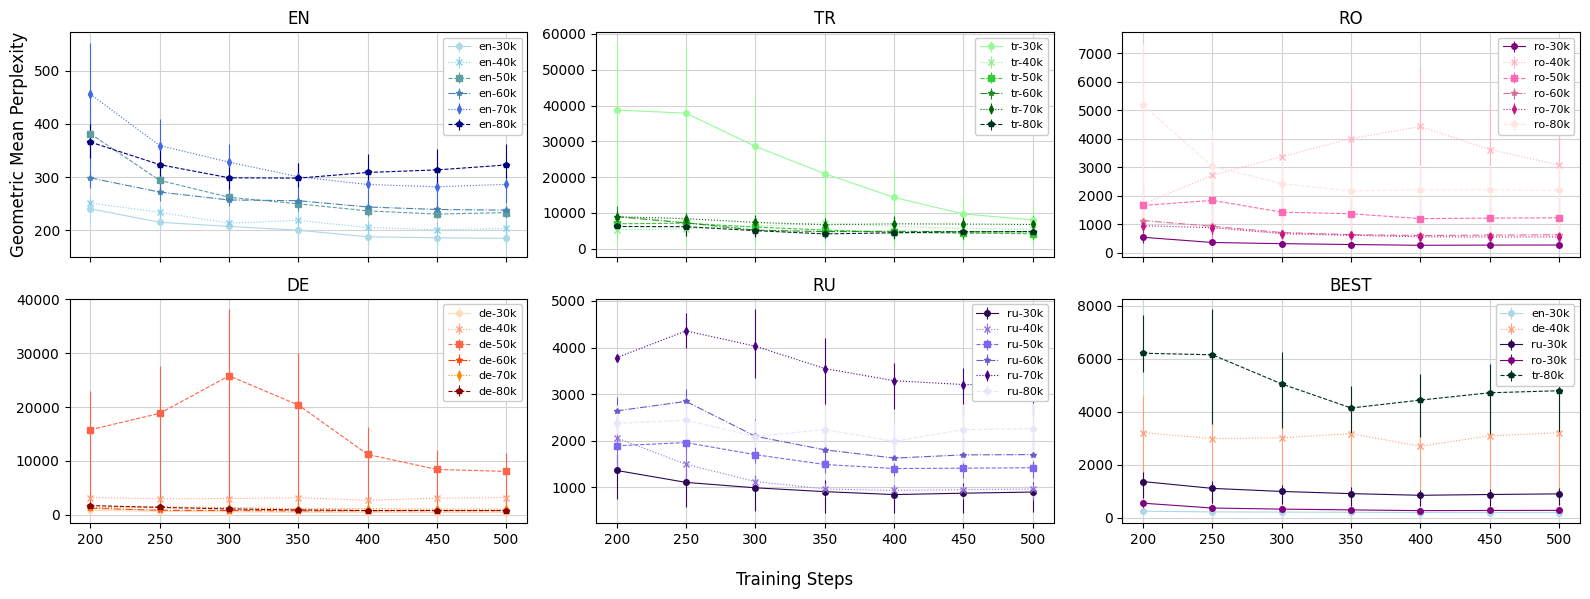

In [ ]:
MAX_TRAINING_STEPS = 500
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 50))
SEEDS = [42,76,81]
# SEEDS = [53]


# Consistent markers for data sizes
marker_info = {
    "30k": 'o',
    "40k": 'x',
    "50k": 's',
    "60k": '*',
    "70k": 'd',
    "80k": 'p'
}

en_info = [
    ("en", "EN", "30000", marker_info["30k"], "-", 'en-30k'),  # Dodger Blue
    ("en", "EN", "40000", marker_info["40k"], ":", 'en-40k'),  # Steel Blue
    ("en", "EN", "50000", marker_info["50k"], "--", 'en-50k'),  # Cadet Blue
    ("en", "EN", "60000", marker_info["60k"], "-.", 'en-60k'),  # New
    ("en", "EN", "70000", marker_info["70k"], ":", 'en-70k'),  # New
    ("en", "EN", "80000", marker_info["80k"], "--", 'en-80k'),  # New
]

de_info = [
    ("de", "DE", "30000", marker_info["30k"], "-", 'de-30k'),  # Orange-Red
    ("de", "DE", "40000", marker_info["40k"], ":", 'de-40k'),  # Tomato
    ("de", "DE", "50000", marker_info["50k"], "--", 'de-50k'),  # Light Salmon
    ("de", "DE", "60000", marker_info["60k"], "-.", 'de-60k'),  # New
    ("de", "DE", "70000", marker_info["70k"], ":", 'de-70k'),  # New
    ("de", "DE", "80000", marker_info["80k"], "--", 'de-80k'),  # New
]

ru_info = [
    ("ru", "RU", "30000", marker_info["30k"], "-", 'ru-30k'),  # Slate Blue
    ("ru", "RU", "40000", marker_info["40k"], ":", 'ru-40k'),  # Medium Purple
    ("ru", "RU", "50000", marker_info["50k"], "--", 'ru-50k'),  # Blue Violet
    ("ru", "RU", "60000", marker_info["60k"], "-.", 'ru-60k'),  # New
    ("ru", "RU", "70000", marker_info["70k"], ":", 'ru-70k'),  # New
    ("ru", "RU", "80000", marker_info["80k"], "--", 'ru-80k'),  # New
]

ro_info = [
    ("ro", "RO", "30000", marker_info["30k"], "-", 'ro-30k'),  # Medium Orchid
    ("ro", "RO", "40000", marker_info["40k"], ":", 'ro-40k'),  # Orchid
    ("ro", "RO", "50000", marker_info["50k"], "--", 'ro-50k'),  # Thistle
    ("ro", "RO", "60000", marker_info["60k"], "-.", 'ro-60k'),  # New
    ("ro", "RO", "70000", marker_info["70k"], ":", 'ro-70k'),  # New
    ("ro", "RO", "80000", marker_info["80k"], "--", 'ro-80k'),  # New
]

tr_info = [
    ("tr", "TR", "30000", marker_info["30k"], "-", 'tr-30k'),  # Forest Green
    ("tr", "TR", "40000", marker_info["40k"], ":", 'tr-40k'),  # Lime Green
    ("tr", "TR", "50000", marker_info["50k"], "--", 'tr-50k'),  # Lawn Green
    ("tr", "TR", "60000", marker_info["60k"], "-.", 'tr-60k'),  # New
    ("tr", "TR", "70000", marker_info["70k"], ":", 'tr-70k'),  # New
    ("tr", "TR", "80000", marker_info["80k"], "--", 'tr-80k'),  # New
    # ("tr", "TR", "pretrain", marker_info["80k"], "--", 'tr-pretrain'),  # New
]

multilingual_info =[("en", "EN", "30000", marker_info["30k"], "-", 'en-30k'),  # Dodger Blue
 ("de", "DE", "40000", marker_info["40k"], ":", 'de-40k'),  # Tomato
 ("ru", "RU", "30000", marker_info["30k"], "-", 'ru-30k'),  # Slate Blue
 ("ro", "RO", "30000", marker_info["30k"], "-", 'ro-30k'),  # Medium Orchid
 ("tr", "TR", "80000", marker_info["80k"], "--", 'tr-80k'),  # New
]


plot_perplexities_grouped([en_info, tr_info, ro_info, de_info, ru_info, multilingual_info],['EN', 'TR', 'RO', 'DE', 'RU', 'BEST'], CHECKPOINTS, SEEDS)
# plt.savefig("tokenization_results.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# all_vas = plot_perplexities_grouped_merge([en_info, de_info, ru_info, ro_info, tr_info], 
#                           ["EN", 'DE', 'RU', 'RO', 'TR'],
#                           CHECKPOINTS, SEEDS)

# all_vas = plot_perplexities_grouped_merge([en_info,ro_info, tr_info], 
#                           ["EN","RO", "TR"],
#                           CHECKPOINTS, SEEDS)

In [ ]:
all_vas = [{x:y} for z in all_vas for x, y in z.items()]

/var/folders/yv/qghkm2153_97xhg4b_zl6j_00000gn/T/ipykernel_32452/3700222845.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = cm.get_cmap('rainbow', len(languages))  # Use a perceptually uniform colormap


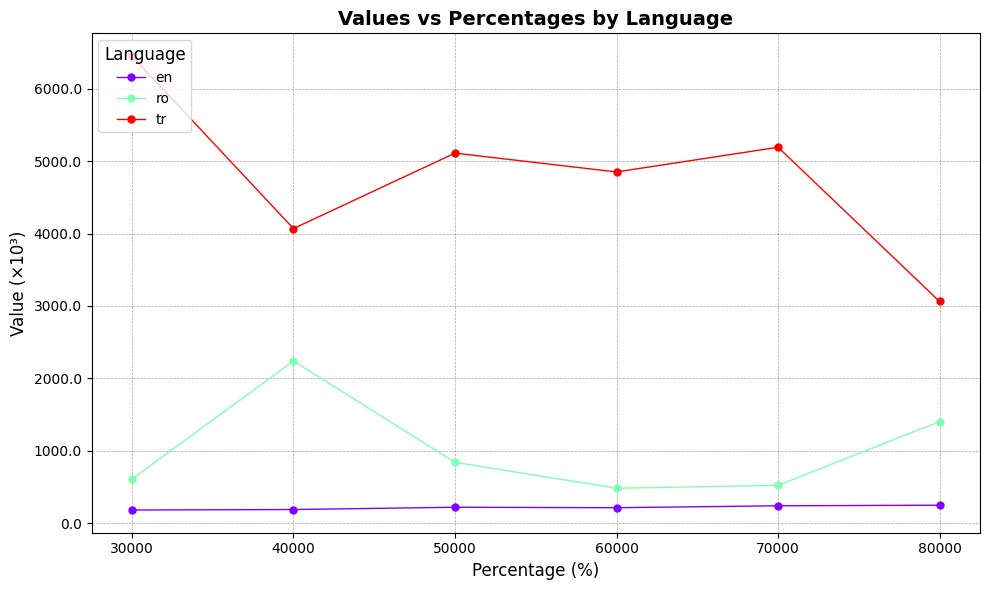

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter

# Data Parsing and Organization
data = {x: y for z in all_vas for x, y in z.items()}  # Combine all data
languages = {}

# Process data by extracting language and percentage, then organizing into a dictionary
for key, value in data.items():
    lang, percentage = key.split('_')
    percentage = float(percentage)
    if lang not in languages:
        languages[lang] = {'x': [], 'y': []}
    languages[lang]['x'].append(percentage)
    languages[lang]['y'].append(value[0])

# Sort values by percentage for smooth plotting
for lang, values in languages.items():
    sorted_indices = sorted(range(len(values['x'])), key=lambda i: values['x'][i])
    languages[lang]['x'] = [values['x'][i] for i in sorted_indices]
    languages[lang]['y'] = [values['y'][i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))  # Set figure size for a compact, professional look
color_palette = cm.get_cmap('rainbow', len(languages))  # Use a perceptually uniform colormap

# Plot each language's data
for idx, (lang, values) in enumerate(languages.items()):
    plt.plot(
        values['x'], 
        values['y'], 
        marker='o', 
        markersize=5,  # Adjust marker size for better clarity
        linewidth=1,   # Use thinner lines for a cleaner look
        label=lang, 
        color=color_palette(idx)
    )

# Axis Labels and Title
plt.xlabel("Percentage (%)", fontsize=12)
plt.ylabel("Value (\u00D710\u00B3)", fontsize=12)  # Use a multiplier for clarity
plt.title("Values vs Percentages by Language", fontsize=14, fontweight='bold')

# Y-axis Formatter to show values in thousands
def thousands_formatter(x, pos):
    return f'{x}'  # Format ticks in terms of thousands

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Legend and Grid
plt.legend(title="Language", loc='upper left', fontsize=10, title_fontsize=12)  # Adjust legend placement and size
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Subtle grid lines for readability

# Adjust layout for neatness
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
PERTURBATIONS = {
    "en_shuffle_control": {"color": "#1E90FF"},  # Dodger Blue
    "ro_shuffle_control": {"color": "#32CD32"},  # Lime Green
    "tr_shuffle_control": {"color": "#FFD700"},  # Gold
    "en_shuffle_deterministic21": {"color": "#4682B4"},  # Steel Blue
    "en_shuffle_deterministic57": {"color": "#5F9EA0"},  # Cadet Blue
    "en_shuffle_local10": {"color": "#FF6347"},  # Tomato
    "en_shuffle_nondeterministic": {"color": "#9400D3"},  # Dark Violet
    "en_shuffle_local5": {"color": "#FF4500"},  # Orange Red
}

marker_info = {
    "30k": 'o',
    "40k": 'x',
    "50k": 's',
    "60k": '*',
    "70k": 'd',
    "80k": 'p'
}

ling_info = [
    ("en", "EN", "shuffle_control", marker_info["30k"], "-", 'en-no_shuffle'),  # Dodger Blue
    ("ro", "RO", "shuffle_control", marker_info["30k"], "-", 'ro-no_shuffle'),
    ("tr", "TR", "shuffle_control", marker_info["30k"], "-", 'tr-no_shuffle'),
    ("en", "EN", "shuffle_deterministic21", marker_info["40k"], ":", 'en-shuffle_deterministic21'),  # Steel Blue
    ("en", "EN", "shuffle_deterministic57", marker_info["50k"], "--", 'en-shuffle_deterministic57'),  # Cadet Blue
    ("en", "EN", "shuffle_local10", marker_info["60k"], "-.", 'en-shuffle_local10'),  # New
    ("en", "EN", "shuffle_nondeterministic", marker_info["70k"], ":", 'en-shuffle_nondeterministic'),  # New
    ("en", "EN", "shuffle_local5", marker_info["80k"], "--", 'en-shuffle_local5'),  # New
]

# de_info = [
#     ("de", "DE", "30000", marker_info["30k"], "-", 'de-30k'),  # Orange-Red
#     ("de", "DE", "40000", marker_info["40k"], ":", 'de-40k'),  # Tomato
#     ("de", "DE", "50000", marker_info["50k"], "--", 'de-50k'),  # Light Salmon
#     ("de", "DE", "60000", marker_info["60k"], "-.", 'de-60k'),  # New
#     ("de", "DE", "70000", marker_info["70k"], ":", 'de-70k'),  # New
#     ("de", "DE", "80000", marker_info["80k"], "--", 'de-80k'),  # New
# ]

# ru_info = [
#     ("ru", "RU", "30000", marker_info["30k"], "-", 'ru-30k'),  # Slate Blue
#     ("ru", "RU", "40000", marker_info["40k"], ":", 'ru-40k'),  # Medium Purple
#     ("ru", "RU", "50000", marker_info["50k"], "--", 'ru-50k'),  # Blue Violet
#     ("ru", "RU", "60000", marker_info["60k"], "-.", 'ru-60k'),  # New
#     ("ru", "RU", "70000", marker_info["70k"], ":", 'ru-70k'),  # New
#     ("ru", "RU", "80000", marker_info["80k"], "--", 'ru-80k'),  # New
# ]

# ro_info = [
#     ("ro", "RO", "30000", marker_info["30k"], "-", 'ro-30k'),  # Medium Orchid
# ]

# tr_info = [
#     ("tr", "TR", "30000", marker_info["30k"], "-", 'tr-30k'),  # Forest Green
#     ("tr", "TR", "40000", marker_info["40k"], ":", 'tr-40k'),  # Lime Green
#     ("tr", "TR", "50000", marker_info["50k"], "--", 'tr-50k'),  # Lawn Green
#     ("tr", "TR", "60000", marker_info["60k"], "-.", 'tr-60k'),  # New
#     ("tr", "TR", "70000", marker_info["70k"], ":", 'tr-70k'),  # New
#     ("tr", "TR", "80000", marker_info["80k"], "--", 'tr-80k'),  # New

In [ ]:
PERTURBATION_m = {
    "en_shuffle_control": {
        "perturbation_function": partial(perturb_shuffle_deterministic, seed=None, shuffle=False),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#606060",
    },
    "en_shuffle_nondeterministic": {
        "perturbation_function": partial(perturb_shuffle_nondeterministic, rng=default_rng(0)),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#E8384F",
    },
    "en_shuffle_deterministic21": {
        "perturbation_function": partial(perturb_shuffle_deterministic, seed=21, shuffle=True),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#FFB000",
    },
    "shuffle_deterministic57": {
        "perturbation_function": partial(perturb_shuffle_deterministic, seed=57, shuffle=True),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#8db000",
    },
    "shuffle_deterministic84": {
        "perturbation_function": partial(perturb_shuffle_deterministic, seed=84, shuffle=True),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#62BB35",
    },
    "shuffle_local3": {
        "perturbation_function": partial(perturb_shuffle_local, seed=0, window=3),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#208EA3",
    },
    "shuffle_local5": {
        "perturbation_function": partial(perturb_shuffle_local, seed=0, window=5),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#4178BC",
    },
    "shuffle_local10": {
        "perturbation_function": partial(perturb_shuffle_local, seed=0, window=10),
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#AA71FF",
    },
    "shuffle_even_odd": {
        "perturbation_function": perturb_shuffle_even_odd,
        "affect_function": affect_shuffle,
        "filter_function": filter_shuffle,
        "gpt2_tokenizer": gpt2_original_tokenizer,
        "color": "#E37CFF",
    },

en-shuffle_deterministic21 100 947.6416034525863
en-shuffle_deterministic21 200 1047.8299139978308
en-shuffle_deterministic21 300 912.4231730190202
en-shuffle_deterministic21 400 773.5478578426984
en-shuffle_deterministic21 500 723.109660261356
en-shuffle_deterministic21 600 633.8803108982285
en-shuffle_deterministic21 700 564.218763344732
en-shuffle_deterministic21 800 539.8876793441686
en-shuffle_deterministic21 900 509.2931442892001
en-shuffle_deterministic21 1000 494.1581412473088
en-shuffle_deterministic21 1100 493.20053580978754
en-shuffle_deterministic21 1200 488.84945580014204
en-shuffle_deterministic21 100 1009.7879356519135
en-shuffle_deterministic21 200 962.9185228584108
en-shuffle_deterministic21 300 846.8519212453781
en-shuffle_deterministic21 400 853.6935103394707
en-shuffle_deterministic21 500 717.6662718377372
en-shuffle_deterministic21 600 672.0973560209675
en-shuffle_deterministic21 700 627.4577736766395
en-shuffle_deterministic21 800 569.1736301012673
en-shuffle_dete

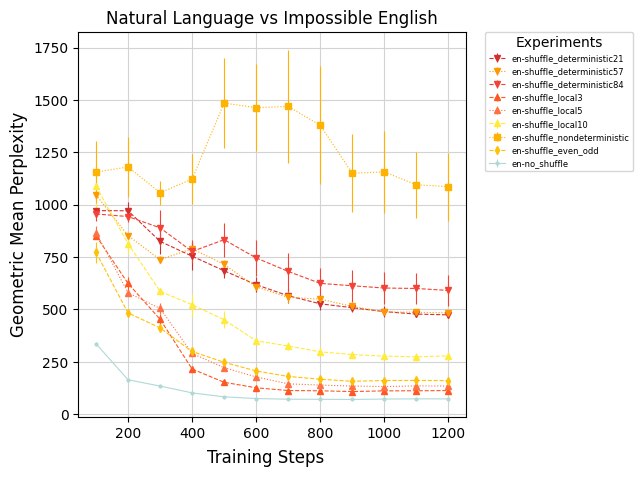

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm

# A gradient of 5 shades of blue

# gradient_colors = [cm.viridis(i / 7.0) for i in range(7)]  # 7 shades of gradient colors
PERTURBATIONS_m = {
    # Shuffle control types (Cold colors - Blue, Purple)
"en_shuffle_control": {"color": "#AFD9D7"},  # Soft Blue
"ro_shuffle_control": {"color": "#5A7898"},  # Cool Blue
"tr_shuffle_control": {"color": "#8A9CCF"},  # Muted Purple
"ru_shuffle_control": {"color": "#7683"},  # Lavender
"nl_shuffle_control": {"color": "#4D4498"},  # Muted Blue
"de_shuffle_control": {"color": "#6F379E"},  # Muted Blue
"fr_shuffle_control": {"color": "black"},  # Muted Blue
"it_shuffle_control": {"color": "gray"},  # Muted Blue
"zh_shuffle_control": {"color": "black"},  # Muted Blue
# More distinguishable soft red, orange, and yellow tones
"en_shuffle_deterministic21": {"color": "#D32F2F"},  # Strong Red
"en_shuffle_deterministic57": {"color": "#FF9800"},  # Bright Orange
"en_shuffle_deterministic84": {"color": "#F44336"},  # Vibrant Red (Coral)

"en_shuffle_local3": {"color": "#FF5722"},  # Deep Orange
"en_shuffle_local5": {"color": "#FF7043"},  # Soft Red-Orange
"en_shuffle_local10": {"color": "#FFEB3B"},  # Bright Yellow

"en_shuffle_nondeterministic": {"color": "#FFB300"},  # Strong Amber Yellow
"en_shuffle_even_odd": {"color": "#FFC107"},  # Golden Yellow
}

ling_info = [
    # English (en) - Deterministic Shuffles
    ("en", "EN", "shuffle_deterministic21", "v", "--", 'en-shuffle_deterministic21'),  # Down Triangle, Solid
    ("en", "EN", "shuffle_deterministic57", "v", ":", 'en-shuffle_deterministic57'),  # Down Triangle, Dashed
    ("en", "EN", "shuffle_deterministic84", "v", "--", 'en-shuffle_deterministic84'),  # Down Triangle, Dotted

    # English (en) - Local Shuffles
    ("en", "EN", "shuffle_local3", "^", "--", 'en-shuffle_local3'),  # Up Triangle, Solid
    ("en", "EN", "shuffle_local5", "^", ":", 'en-shuffle_local5'),  # Up Triangle, Dashed
    ("en", "EN", "shuffle_local10", "^", "--", 'en-shuffle_local10'),  # Up Triangle, Dotted

    # English (en) - Nondeterministic and Even-Odd
    ("en", "EN", "shuffle_nondeterministic", "s", ":", 'en-shuffle_nondeterministic'),  # Square, Dashed
    ("en", "EN", "shuffle_even_odd", "d", "--", 'en-shuffle_even_odd'),  # Diamond, Dotted

    # Shuffle Control with Language Abbreviation as Marker
    ("en", "EN", "shuffle_control", ".", "-", 'en-no_shuffle'),  # Language Abbreviation for EN
    # ("ro", "RO", "shuffle_control", ".", "-", 'ro-no_shuffle'),  # Language Abbreviation for RO
    # ("tr", "TR", "shuffle_control", ".", "-", 'tr-no_shuffle'),  # Language Abbreviation for TR
    # ("ru", "RU", "shuffle_control", ".", "-", 'ru-no_shuffle'),  # Language Abbreviation for RU
    # ("nl", "NL", "shuffle_control", ".", "-", 'nl-no_shuffle') ,  # Language Abbreviation for NL
    # ("de", "DE", "shuffle_control", ".", "-", 'de-no_shuffle') ,  # Language Abbreviation for NL
    # # ("fr", "FR", "shuffle_control", ".", "-", 'fr-no_shuffle'),   # Language Abbreviation for NL
    #  ("it", "IT", "shuffle_control", ".", "-", 'it-no_shuffle') ,  # Language Abbreviation for NL 
    #  ("zh", "ZH", "shuffle_control", ".", "-", 'zh-no_shuffle')   
]


SEEDS = [41,53,81]  # Single seed case
CHECKPOINTS = list(range(100, 1200+1, 100))

def plot_mean_perplexities_multilingual(ax_i, ax, file_info, title, checkpoints, seeds, PERTURBATION):
    results_path = '/Users/xiulinyang/Desktop/test/mission-impossible-language-models/perplexities/multilingual_pretrain/randinit_seed{}_test_{}_{}_pretrained.csv'
    
    for file_data in file_info:
        lang, lang2, permutation, marker, linestyle, legend_name = file_data
        all_seeds_gmeans = []
        
        for seed in seeds:
            df = pd.read_csv(results_path.format(seed, permutation, lang), lineterminator='\n')
            # print(f"Data for seed {seed} and {lang}:\n", df.head())  # Debugging line
            
            gmeans = [stats.gmean(df[f"Perplexities (ckpt {ckpt})"]) for ckpt in checkpoints]
            for k, ckpt in enumerate(checkpoints):
                print(legend_name, ckpt, gmeans[k])
            
            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)
       
        # print(f"Means for {lang}: {means}")  # Debugging line
        
        # If more than one seed, calculate confidence intervals
        if len(seeds) > 1:
            ci = stats.sem(all_seeds_gmeans, axis=0)
        else:
            ci = None  # No confidence interval for a single seed

        # Plotting the graph
        if ci is not None:
            # if permutation =='shuffle_control':
            #     ax.errorbar(checkpoints, means, yerr=ci, marker=marker, markersize=5,  linewidth=0.8,markeredgewidth=1.5, 
            #                 color=PERTURBATIONS_m[f'{lang}_{permutation}']["color"],
            #                 linestyle=linestyle, label=legend_name)

            # else:
            ax.errorbar(checkpoints, means, yerr=ci, marker=marker, markersize=4, linewidth=0.8,
                        color=PERTURBATION[f'{permutation}']["color"],
                        linestyle=linestyle, label=legend_name)
        else:
            ax.plot(checkpoints, means, marker=marker, markersize=4,linewidth=0.8,
                    color=PERTURBATION[f'{permutation}']["color"],
                    linestyle=linestyle, label=legend_name)
        
        ax.set_title(title)
        ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
        ax.grid(True, color="lightgray")
        ax.legend(fontsize=6, framealpha=1)

def plot_perplexities_multilingual(file_info, title, checkpoints, seeds,PERTURBATIONS_m, output_name):
    # Create the figure and a single axis (axs)
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    plot_mean_perplexities_multilingual(0, ax, file_info, title, checkpoints, seeds,PERTURBATIONS_m)
    ax.legend(title="Experiments", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=6, borderaxespad=0.)
    plt.savefig(output_name, format="pdf", bbox_inches="tight")
    print(f"Plot saved as {output_name}.pdf")

    plt.show()
    

plot_perplexities_multilingual(ling_info, "Natural Language vs Impossible English", CHECKPOINTS, SEEDS, PERTURBATIONS_m, 'multli.pdf')


ERROR: Could not find a version that satisfies the requirement paletteer (from versions: none)
ERROR: No matching distribution found for paletteer


Plot saved as multilingual.pdf


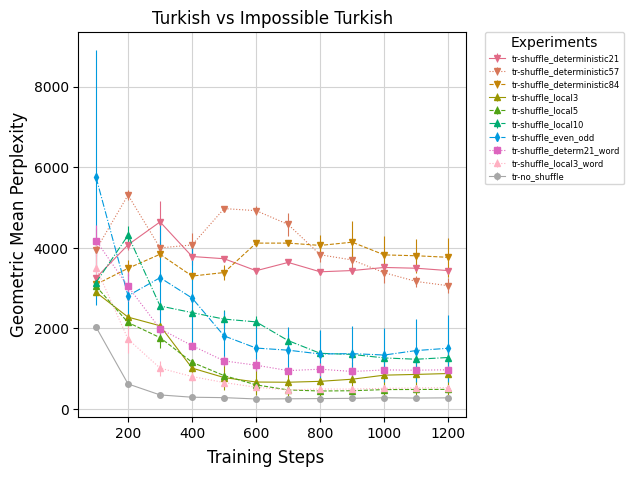

In [ ]:
tr_info = [
    # Turkish (tr) - Deterministic Shuffles
    ("tr", "TR", "shuffle_deterministic21", "v", "-", 'tr-shuffle_deterministic21'),  # Down Triangle, Solid
    ("tr", "TR", "shuffle_deterministic57", "v", ":", 'tr-shuffle_deterministic57'),  # Down Triangle, Dotted
    ("tr", "TR", "shuffle_deterministic84", "v", "--", 'tr-shuffle_deterministic84'),  # Down Triangle, Dashed

    # Turkish (tr) - Local Shuffles
    ("tr", "TR", "shuffle_local3", "^", "-", 'tr-shuffle_local3'),  # Up Triangle, Solid
    ("tr", "TR", "shuffle_local5", "^", "--", 'tr-shuffle_local5'),  # Up Triangle, Dashed
    ("tr", "TR", "shuffle_local10", "^", "-.", 'tr-shuffle_local10'),  # Up Triangle, Dash-Dot
    ("tr", "TR", "shuffle_even_odd", "d", "-.", 'tr-shuffle_even_odd'),  # Diamond, Dash-Dot
   
    # Turkish (tr) - Nondeterministic and Even-Odd

    ("tr", "TR", "shuffle_deterministic21_word", "s", ":", 'tr-shuffle_determ21_word'),  # Square, Dotted
        ("tr", "TR", "shuffle_local3_word", "^", ":", 'tr-shuffle_local3_word'),  # Up Triangle, Dotted
     ("tr", "TR", "shuffle_control", "o", "-", 'tr-no_shuffle'),  # Circle, Solid
    
]
SEEDS = [53,41]  # Single seed case
CHECKPOINTS = list(range(100, 1200+1, 100))
PERTURBATIONS_tr = {
    # Red Tones
    "shuffle_deterministic21": {"color": "#E16A86"},  # Light Red
    "huffle_deterministic57": {"color": "#D77658"},  # Soft Salmon Pink

    "shuffle_deterministic84": {"color": "#C48407"},  # Light Apricot Orange
    "shuffle_local3": {"color": "#999600"},  # Soft Peach
    "shuffle_local5": {"color": "#50A315"},  # Soft Pastel Yellow
    "shuffle_local10": {"color": "#00AC71"},  # Soft Pastel Green
    "shuffle_even_odd": {"color": "#009ADE"},  # Soft Light Blue
     "shuffle_control": {"color": "#A7A7A7"},
  
    "shuffle_deterministic21_word": {"color": "#DD64BE"}, 
    "shuffle_local3_word": {"color": "#FFB0C2"},

}
plot_perplexities_multilingual(tr_info, "Turkish vs Impossible Turkish", CHECKPOINTS, SEEDS, PERTURBATIONS_tr, 'tr.pdf')


## Results with different warm-up hyperparameters

In [ ]:
from pathlib import Path
values = Path('value_output.txt').read_text().strip().split('\n')
dict_out = {}
for v in values:
    exp, checkpoint, va = v.split()
    if exp not in dict_out:
        dict_out[exp] = {checkpoint: [va]}
        
    else:
        if checkpoint not in dict_out[exp]:
            dict_out[exp][checkpoint] = [va]
        else:
            dict_out[exp][checkpoint].append(va)

In [ ]:
import statistics as s
dict_to_write = {}
for k,v in dict_out.items():
    dict_to_write[k]=[]
    for step, value in v.items():
        dict_to_write[k].append(s.mean([float(x) for x in value]))


In [ ]:
for k, v in dict_to_write.items():
    v= [str(x) for x in v]
    v = ','.join(v)
    print(f'{k} = c({v}),')

en-shuffle_deterministic21 = c(971.4584659123199,970.8447935924567,824.6238841829362,754.0160500355839,684.2697778872753,617.7587326121882,565.0563811151034,526.6445878062815,507.9517382283054,489.2369666714314,477.5182447666612,473.81611619003615),
en-shuffle_deterministic57 = c(1046.7266576929821,852.2659988624047,737.8352237714416,789.2637262386831,714.613182800651,607.6184695785521,557.3366816359353,548.9931156572578,514.2787378479912,487.2852981462279,486.50859109675946,483.1068396776892),
en-shuffle_deterministic84 = c(955.5770877270178,943.1459945626661,889.3545078598851,776.4648778847076,832.6629507443972,745.6126432995628,681.3176005459727,624.1351783621848,612.6940025163306,601.8694299728252,599.8229975359309,590.2514128782371),
en-shuffle_local3 = c(851.5472191415548,623.7436008095777,452.9677320840701,215.46121449362158,151.89808470498193,125.67625371588177,112.57418632130545,111.29758195662237,107.5256349430429,110.95547210617987,111.33985683281819,112.43728509055529),
en-

en-no_shuffle 300 133.5420556552744
en-no_shuffle 400 103.63033017978414
en-no_shuffle 500 84.2167849298236
en-no_shuffle 600 73.87890644910166
en-no_shuffle 700 70.88365510518526
en-no_shuffle 800 70.5949445176158
en-no_shuffle 900 70.04062802461412
en-no_shuffle 1000 71.68053194694883
en-no_shuffle 1100 73.1851749306865
en-no_shuffle 1200 72.89923823272542
en-no_shuffle 300 133.95636781864042
en-no_shuffle 400 98.72462702888741
en-no_shuffle 500 81.97261536754553
en-no_shuffle 600 73.162305328704
en-no_shuffle 700 72.00672769654501
en-no_shuffle 800 69.05591830033312
en-no_shuffle 900 70.31004590111601
en-no_shuffle 1000 72.17263570693791
en-no_shuffle 1100 72.21694898014022
en-no_shuffle 1200 72.10584282549068
de-no_shuffle 300 315.81394678075225
de-no_shuffle 400 234.39418131559083
de-no_shuffle 500 180.57068994466374
de-no_shuffle 600 141.7790974783016
de-no_shuffle 700 130.11168701211187
de-no_shuffle 800 125.78968525701784
de-no_shuffle 900 116.96478495567541
de-no_shuffle 1000 

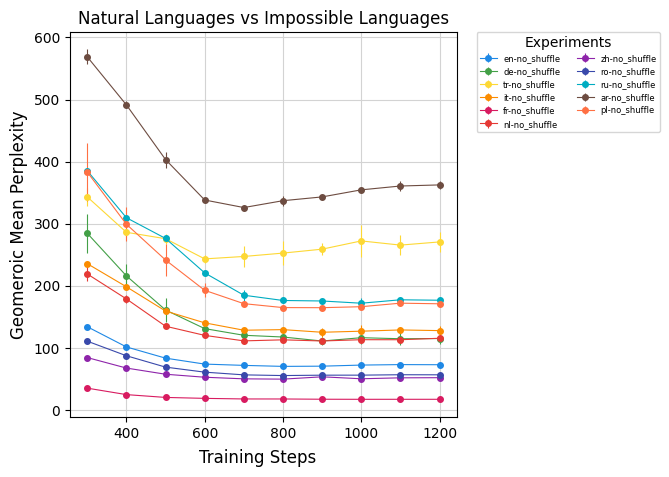

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm

# A gradient of 5 shades of blue
SEEDS = [41, 53]  # Single seed case
CHECKPOINTS = list(range(300, 1200 + 1, 100))

'''
# Turkish (ro) - Deterministic Shuffles
("en", "EN", "perturb_num_adj", "^", ":", 'en-perturb_num_adj'),
("en", "EN", "perturb_adj_num", "^", ":", 'en-perturb_adj_num'),  # Up Triangle, Dotted
("en", "EN", "shuffle_deterministic21_word", "s", ":", 'en-shuffle_determ21_word'),  # Square, Dotted
("en", "EN", "shuffle_local_word3", "^", ":", 'en-shuffle_local3_word'),  # Up Triangle, Dotted
("en", "EN", "shuffle_remove_fw", "^", ":", 'en-shuffle_remove_fw'),  # Up Triangle, Dotted
'''

ling_info = [
    # English (EN)
    # ("en", "EN", "shuffle_deterministic21", "v", "-", 'en-shuffle_deterministic21'),  # Down Triangle, Solid
    # ("en", "EN", "shuffle_deterministic57", "v", ":", 'en-shuffle_deterministic57'),  # Down Triangle, Dotted
    # ("en", "EN", "shuffle_deterministic84", "v", "--", 'en-shuffle_deterministic84'),  # Down Triangle, Dashed
    # ("en", "EN", "shuffle_local2", "^", "-", 'en-shuffle_local2'),
    # ("en", "EN", "shuffle_local3", "^", "-", 'en-shuffle_local3'),  # Up Triangle, Solid
    # ("en", "EN", "shuffle_local5", "^", "--", 'en-shuffle_local5'),  # Up Triangle, Dashed
    # ("en", "EN", "shuffle_local10", "^", "-.", 'en-shuffle_local10'),  # Up Triangle, Dash-Dot
    # ("en", "EN", "shuffle_even_odd", "d", "-.", 'en-shuffle_even_odd'),  # Diamond, Dash-Dot

    #
    # # # German (DE)
    
    # ("de", "DE", "shuffle_deterministic21", "v", "-", 'de-shuffle_deterministic21'),
    # ("de", "DE", "shuffle_deterministic57", "v", ":", 'de-shuffle_deterministic57'),
    # ("de", "DE", "shuffle_deterministic84", "v", "--", 'de-shuffle_deterministic84'),
    # ("de", "DE", "shuffle_local3", "^", "-", 'de-shuffle_local3'),
    # ("de", "DE", "shuffle_local5", "^", "--", 'de-shuffle_local5'),
    # ("de", "DE", "shuffle_local10", "^", "-.", 'de-shuffle_local10'),
    # ("de", "DE", "shuffle_even_odd", "d", "-.", 'de-shuffle_even_odd'),

    #
    # # Turkish (TR)
    # ("tr", "TR", "shuffle_deterministic21", "v", "-", 'tr-shuffle_deterministic21'),
    # ("tr", "TR", "shuffle_deterministic57", "v", ":", 'tr-shuffle_deterministic57'),
    # ("tr", "TR", "shuffle_deterministic84", "v", "--", 'tr-shuffle_deterministic84'),
    # ("tr", "TR", "shuffle_local3", "^", "-", 'tr-shuffle_local3'),
    # ("tr", "TR", "shuffle_local5", "^", "--", 'tr-shuffle_local5'),
    # ("tr", "TR", "shuffle_local10", "^", "-.", 'tr-shuffle_local10'),
    # ("tr", "TR", "shuffle_even_odd", "d", "-.", 'tr-shuffle_even_odd'),

    # #
    # # # Italian (IT)
    # ("it", "IT", "shuffle_deterministic21", "v", "-", 'it-shuffle_deterministic21'),
    # ("it", "IT", "shuffle_deterministic57", "v", ":", 'it-shuffle_deterministic57'),
    # ("it", "IT", "shuffle_deterministic84", "v", "--", 'it-shuffle_deterministic84'),
    # ("it", "IT", "shuffle_local3", "^", "-", 'it-shuffle_local3'),
    # ("it", "IT", "shuffle_local5", "^", "--", 'it-shuffle_local5'),
    # ("it", "IT", "shuffle_local10", "^", "-.", 'it-shuffle_local10'),
    # ("it", "IT", "shuffle_even_odd", "d", "-.", 'it-shuffle_even_odd'),


    # # Dutch (NL)
    # ("nl", "NL", "shuffle_deterministic21", "v", "-", 'nl-shuffle_deterministic21'),
    # ("nl", "NL", "shuffle_deterministic57", "v", ":", 'nl-shuffle_deterministic57'),
    # ("nl", "NL", "shuffle_deterministic84", "v", "--", 'nl-shuffle_deterministic84'),
    # ("nl", "NL", "shuffle_local3", "^", "-", 'nl-shuffle_local3'),
    # ("nl", "NL", "shuffle_local5", "^", "--", 'nl-shuffle_local5'),
    # ("nl", "NL", "shuffle_local10", "^", "-.", 'nl-shuffle_local10'),
    # ("nl", "NL", "shuffle_even_odd", "d", "-.", 'nl-shuffle_even_odd'),


    # # # # Chinese (ZH)
    # ("zh", "ZH", "shuffle_deterministic21", "v", "-", 'zh-shuffle_deterministic21'),
    # ("zh", "ZH", "shuffle_deterministic57", "v", ":", 'zh-shuffle_deterministic57'),
    # ("zh", "ZH", "shuffle_deterministic84", "v", "--", 'zh-shuffle_deterministic84'),
    # ("zh", "ZH", "shuffle_local3", "^", "-", 'zh-shuffle_local3'),
    # ("zh", "ZH", "shuffle_local5", "^", "--", 'zh-shuffle_local5'),
    # ("zh", "ZH", "shuffle_local10", "^", "-.", 'zh-shuffle_local10'),
    # ("zh", "ZH", "shuffle_even_odd", "d", "-.", 'zh-shuffle_even_odd'),
    
    # ("ar", "AR", "shuffle_deterministic21", "v", "-", 'ar-shuffle_deterministic21'),
    # ("ar", "AR", "shuffle_deterministic57", "v", ":", 'ar-shuffle_deterministic57'),
    # ("ar", "AR", "shuffle_deterministic84", "v", "--", 'ar-shuffle_deterministic84'),
    # ("ar", "AR", "shuffle_local3", "^", "-", 'ar-shuffle_local3'),
    # ("ar", "AR", "shuffle_local5", "^", "--", 'ar-shuffle_local5'),
    # ("ar", "AR", "shuffle_local10", "^", "-.", 'ar-shuffle_local10'),
    # ("ar", "AR", "shuffle_even_odd", "d", "-.", 'ar-shuffle_even_odd'),
    
    
    # ("pl", "PL", "shuffle_deterministic21", "v", "-", 'pl-shuffle_deterministic21'),
    # ("pl", "PL", "shuffle_deterministic57", "v", ":", 'pl-shuffle_deterministic57'),
    # ("pl", "PL", "shuffle_deterministic84", "v", "--", 'pl-shuffle_deterministic84'),
    # ("pl", "PL", "shuffle_local3", "^", "-", 'pl-shuffle_local3'),
    # ("pl", "PL", "shuffle_local5", "^", "--", 'pl-shuffle_local5'),
    # ("pl", "PL", "shuffle_local10", "^", "-.", 'pl-shuffle_local10'),
    # ("pl", "PL", "shuffle_even_odd", "d", "-.", 'pl-shuffle_even_odd'),
    # #
    # # #
    # # # # Romanian (RO)
    # ("ro", "RO", "shuffle_deterministic21", "v", "-", 'ro-shuffle_deterministic21'),
    # ("ro", "RO", "shuffle_deterministic57", "v", ":", 'ro-shuffle_deterministic57'),
    # ("ro", "RO", "shuffle_deterministic84", "v", "--", 'ro-shuffle_deterministic84'),
    # ("ro", "RO", "shuffle_local3", "^", "-", 'ro-shuffle_local3'),
    # ("ro", "RO", "shuffle_local5", "^", "--", 'ro-shuffle_local5'),
    # ("ro", "RO", "shuffle_local10", "^", "-.", 'ro-shuffle_local10'),
    # ("ro", "RO", "shuffle_even_odd", "d", "-.", 'ro-shuffle_even_odd'),

    # #
    # # # Russian (RU)
    # # ("ru", "RU", "shuffle_deterministic21", "v", "-", 'ru-shuffle_deterministic21'),
    # ("ru", "RU", "shuffle_deterministic57", "v", ":", 'ru-shuffle_deterministic57'),
    # ("ru", "RU", "shuffle_deterministic84", "v", "--", 'ru-shuffle_deterministic84'),
    # ("ru", "RU", "shuffle_local3", "^", "-", 'ru-shuffle_local3'),
    # ("ru", "RU", "shuffle_local5", "^", "--", 'ru-shuffle_local5'),
    # ("ru", "RU", "shuffle_local10", "^", "-.", 'ru-shuffle_local10'),
    # ("ru", "RU", "shuffle_even_odd", "d", "-.", 'ru-shuffle_even_odd'),

("en", "EN", "shuffle_control", "o", "-", 'en-no_shuffle'),
("de", "DE", "shuffle_control", "o", "-", 'de-no_shuffle'),
("tr", "TR", "shuffle_control", "o", "-", 'tr-no_shuffle'),
("it", "IT", "shuffle_control", "o", "-", 'it-no_shuffle'),

("fr", "FR", "shuffle_control", "o", "-", 'fr-no_shuffle'),

("nl", "NL", "shuffle_control", "o", "-", 'nl-no_shuffle'),
("zh", "ZH", "shuffle_control", "o", "-", 'zh-no_shuffle'),
("ro", "RO", "shuffle_control", "o", "-", 'ro-no_shuffle'),
("ru", "RU", "shuffle_control", "o", "-", 'ru-no_shuffle'),
("ar", "AR", "shuffle_control", "o", "-", 'ar-no_shuffle'),
    ("pl", "PL", "shuffle_control", "o", "-", 'pl-no_shuffle'),
]


PERTURBATIONS = {
    # Red Tones
    "perturb_adj_num":{"color":"#D6DFEC" },
    "perturb_num_adj": {"color": "#D6DFEC"},
    "shuffle_deterministic21": {"color": "#D6DFEC"},  # Light Red
    "shuffle_deterministic57": {"color": "#D6DFEC"},  # Soft Salmon Pink
    "shuffle_remove_fw": {"color": "#D6DFEC"},  # Soft Salmon Pink
    "shuffle_deterministic84": {"color": "#D6DFEC"},  # Light Apricot Orange
    "shuffle_local2":{"color":"#EABF23" },
    "shuffle_local3": {"color": "#D6DFEC"},  # Soft Peach
    "shuffle_local5": {"color": "#D6DFEC"},  # Soft Pastel Yellow
    "shuffle_local10": {"color": "#D6DFEC"},  # Soft Pastel Green
    "shuffle_even_odd": {"color": "#D6DFEC"},  # Soft Light Blue

    "shuffle_deterministic21_word": {"color": "#D6DFEC"},
    "shuffle_local_word3": {"color": "#D6DFEC"},
     "shuffle_control": {
   "EN": "#1E88E5",
    "DE": "#43A047",
    "TR": "#FDD835",
    "IT": "#FB8C00",
    "NL": "#E53935",
    "ZH": "#8E24AA",
    "RO": "#3949AB",
    "RU": "#00ACC1",
    "AR": "#6D4C41",
    "PL": "#FF7043",
    "FR": "#D81B60"
}

}


def plot_mean_perplexities_multilingual(ax_i, ax, file_info, title, checkpoints, seeds, PERTURBATION):
    results_path = 'perplexity_results/{}_{}/randinit_seed{}_test_{}_{}_pretrained.csv'

    for file_data in file_info:
        lang, lang2, permutation, marker, linestyle, legend_name = file_data
        all_seeds_gmeans = []

        for seed in seeds:
            df = pd.read_csv(results_path.format(permutation, lang2, seed, permutation, lang), lineterminator='\n')
            # print(f"Data for seed {seed} and {lang}:\n", df.head())  # Debugging line

            gmeans = [stats.gmean(df[f"Perplexities (ckpt {ckpt})"]) for ckpt in checkpoints]
            for k, ckpt in enumerate(checkpoints):
                print(legend_name, ckpt, gmeans[k])

            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)

        # print(f"Means for {lang}: {means}")  # Debugging line

        # If more than one seed, calculate confidence intervals
        if len(seeds) > 1:
            ci = stats.sem(all_seeds_gmeans, axis=0)
        else:
            ci = None  # No confidence interval for a single seed

        if permutation =='shuffle_control':
            colorp = PERTURBATION[f'{permutation}'][lang2]
        else:
            colorp = PERTURBATION[f'{permutation}']["color"]
        if ci is not None:
            ax.errorbar(checkpoints, means, yerr=ci, marker=marker, markersize=4, linewidth=0.8,
                        color= colorp,
                        linestyle=linestyle, label=legend_name)
        else:
            ax.plot(checkpoints, means, marker=marker, markersize=4, linewidth=0.8,
                    color=colorp,
                    linestyle=linestyle, label=legend_name)

        ax.set_title(title)
        ax.set_ylabel("Geomeroic Mean Perplexity", fontsize=12)
        ax.grid(True, color="lightgray")
        ax.legend(fontsize=5, framealpha=1)


def plot_perplexities_multilingual(file_info, title, checkpoints, seeds, PERTURBATIONS_m, output_name):
    # Create the figure and a single axis (axs)
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    plot_mean_perplexities_multilingual(0, ax, file_info, title, checkpoints, seeds, PERTURBATIONS_m)
    ax.legend(title="Experiments", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=6, ncol=2, borderaxespad=0.)
    plt.savefig(output_name, format="pdf", bbox_inches="tight")
    print(f"Plot saved as {output_name}.pdf")

    plt.show()


plot_perplexities_multilingual(ling_info, "Natural Languages vs Impossible Languages", CHECKPOINTS, SEEDS, PERTURBATIONS,
                               'LM.pdf')

In [18]:
from glob import glob 
import pandas as pd
CHECKPOINTS = list(range(0, 1200 + 1, 100))
perp_csv = sorted(glob('perplexity_results/**/*.csv', recursive=True))
with open('perplexity_results.csv', 'w') as res:
     header = ['lang', 'perturb', 'seed'] + [f'checkpoint{ckpt}' for ckpt in CHECKPOINTS]
     res.write(','.join(header) + '\n')
     for p in perp_csv:
        print(p)
        row = []
        seed = p.split('seed')[1].split('_')[0]
        lang = p.split('/')[-2].split('_')[-1]
        perturb = '_'.join(p.split('/')[-2].split('_')[:-1])
        row.extend([lang, perturb,seed])

        all_seeds_gmeans = []
        df = pd.read_csv(p,lineterminator='\n')
        gmeans = [stats.gmean(df[f"Perplexities (ckpt {ckpt})"]) for ckpt in CHECKPOINTS]
        row+=gmeans
        res.write(','.join(map(str, row)) + '\n')



perplexity_results/perturb_adj_num_EN/randinit_seed41_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_EN/randinit_seed53_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_EN/randinit_seed81_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_num_adj_EN/randinit_seed41_test_perturb_num_adj_en_pretrained.csv
perplexity_results/perturb_num_adj_EN/randinit_seed53_test_perturb_num_adj_en_pretrained.csv
perplexity_results/perturb_num_adj_EN/randinit_seed81_test_perturb_num_adj_en_pretrained.csv
perplexity_results/shuffle_control_AR/randinit_seed41_test_shuffle_control_ar_pretrained.csv
perplexity_results/shuffle_control_AR/randinit_seed53_test_shuffle_control_ar_pretrained.csv
perplexity_results/shuffle_control_AR/randinit_seed81_test_shuffle_control_ar_pretrained.csv
perplexity_results/shuffle_control_DE/randinit_seed41_test_shuffle_control_de_pretrained.csv
perplexity_results/shuffle_control_DE/randinit_seed53_test_shuffle_con

In [21]:
import pandas as pd
results = pd.read_csv('perplexity_results.tsv', sep='\t')
filtered_df = results[results['lang'].str.contains('EN', na=False)]

In [22]:
filtered_df

,lang,perturb,seed,checkpoint300,checkpoint400,checkpoint500,checkpoint600,checkpoint700,checkpoint800,checkpoint900,checkpoint1000,checkpoint1100,checkpoint1200
0,EN,perturb_adj_num,41,134.008054,101.205637,80.959520,74.720295,71.209426,68.749459,73.383364,74.003967,74.728481,74.266071
1,EN,perturb_adj_num,53,132.881329,103.935464,83.222194,74.227846,72.379357,71.554424,69.388090,72.073594,73.801441,73.025624
2,EN,perturb_adj_num,81,132.685876,104.050662,81.748243,76.082681,71.597128,69.486812,73.197419,72.402923,73.740317,73.166646
3,EN,perturb_num_adj,41,133.129259,98.772430,84.122246,74.141843,71.208655,72.064083,73.759985,74.351478,75.922029,75.825711
4,EN,perturb_num_adj,53,130.052299,96.325463,77.405009,72.341117,71.244261,69.424073,69.986150,72.467309,73.484083,73.515599
5,EN,perturb_num_adj,81,131.846613,102.019319,83.755841,78.695752,74.515872,71.850545,74.678270,76.344902,74.370761,75.363028
9,EN,shuffle_control,41,133.542056,103.630330,84.216785,73.878906,70.883655,70.594945,70.040628,71.680532,73.185175,72.899238
10,EN,shuffle_control,53,133.956368,98.724627,81.972615,73.162305,72.006728,69.055918,70.310046,72.172636,72.216949,72.105843
11,EN,shuffle_control,81,134.047089,101.918351,81.240034,75.645622,70.680181,72.413382,69.628531,71.742825,73.019024,72.976955
36,EN,shuffle_deterministic21,41,912.423173,773.547858,723.109660,633.880311,564.218763,539.887679,509.293144,494.158141,493.200536,488.849456
